In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torch.optim as optim
import pandas as pd
import os
import time
import pickle as pkl

In [66]:
with open('tiny-imagenet-200/words.txt', 'r') as f:
    image_dict = {}
    for line in f:
        line = (line.strip('\n').split('\t'))
        image_dict[line[0]] = line[1]

In [3]:
# Code used from https://github.com/tjmoon0104/pytorch-tiny-imagenet/blob/master/Final_Test.ipynb

%time data_transforms = {\
    'train': transforms.Compose({\
        transforms.ToTensor()}),\
    'test': transforms.Compose({\
        transforms.ToTensor()}),\
    'val': transforms.Compose({\
        transforms.ToTensor()})\
}

data_dir = 'tiny-imagenet-200/'
num_workers = {
    'train' : 100,
    'val' : 0,
    'test' : 0
}

%time image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])\
                                       for x in ['train', 'val', 'test']}
%time dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=100,\
               shuffle=True, num_workers=num_workers[x]) for x in ['train', 'test', 'val']}

%time dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 11.7 µs
CPU times: user 382 ms, sys: 251 ms, total: 634 ms
Wall time: 1.06 s
CPU times: user 81 µs, sys: 0 ns, total: 81 µs
Wall time: 83.9 µs
CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 7.87 µs


In [4]:
dataloaders['test']

In [5]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cpu


In [60]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3, padding=1)
        
        self.fc1   = nn.Linear(30*8*8, 1000)
        self.fc2   = nn.Linear(1000, 200)
        #self.fc3   = nn.Linear(2000, 200)
        #self.fc4   = nn.Linear(900, 200)
        
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.pool1(F.leaky_relu(self.conv1(x)))
        #print(x.size())
        x = self.pool1(F.leaky_relu(self.conv2(x)))
        x = self.pool1(F.leaky_relu(self.conv3(x)))
        #print(x.size())
        x = self.dropout(x.view(-1, 30*8*8))
        #print(x.size())
        
        x = F.leaky_relu(self.fc1(x))
        #print(x.size())
        x = F.leaky_relu(self.fc2(x))
        return x

net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1920, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=200, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [61]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
#         self.pool  = nn.AvgPool2d(2, 2)
#         self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
#         self.fc1   = nn.Linear(20*16*16, 2000)
#         self.fc2   = nn.Linear(2000, 200)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         #print(x.size())
#         x = self.pool(F.relu(self.conv2(x)))
#         #print(x.size())
#         x = x.view(-1, 20*16*16)
#         #print(x.size())
        
#         x = F.relu(self.fc1(x))
#         #print(x.size())
        
#         x = self.fc2(x)
#         #print(x.size())
        
#         return x

# net = Net()     # Create the network instance.
# net.to(device)  # Move the network parameters to the specified device.

In [62]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(net.parameters(), lr=0.004, momentum=0.8) 

In [63]:
%%time
avg_losses = []
epochs = 50
print_freq = 100

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(dataloaders['train'], 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 5.298
[epoch: 0, i:   199] avg mini-batch loss: 5.299
[epoch: 0, i:   299] avg mini-batch loss: 5.298
[epoch: 0, i:   399] avg mini-batch loss: 5.298
[epoch: 0, i:   499] avg mini-batch loss: 5.298
[epoch: 0, i:   599] avg mini-batch loss: 5.298
[epoch: 0, i:   699] avg mini-batch loss: 5.298
[epoch: 0, i:   799] avg mini-batch loss: 5.298
[epoch: 0, i:   899] avg mini-batch loss: 5.298
[epoch: 0, i:   999] avg mini-batch loss: 5.298
[epoch: 1, i:    99] avg mini-batch loss: 5.298
[epoch: 1, i:   199] avg mini-batch loss: 5.298
[epoch: 1, i:   299] avg mini-batch loss: 5.298
[epoch: 1, i:   399] avg mini-batch loss: 5.298
[epoch: 1, i:   499] avg mini-batch loss: 5.298
[epoch: 1, i:   599] avg mini-batch loss: 5.298
[epoch: 1, i:   699] avg mini-batch loss: 5.298
[epoch: 1, i:   799] avg mini-batch loss: 5.298
[epoch: 1, i:   899] avg mini-batch loss: 5.298
[epoch: 1, i:   999] avg mini-batch loss: 5.298
[epoch: 2, i:    99] avg mini-batch loss

[epoch: 17, i:    99] avg mini-batch loss: 3.722
[epoch: 17, i:   199] avg mini-batch loss: 3.743
[epoch: 17, i:   299] avg mini-batch loss: 3.778
[epoch: 17, i:   399] avg mini-batch loss: 3.785
[epoch: 17, i:   499] avg mini-batch loss: 3.799
[epoch: 17, i:   599] avg mini-batch loss: 3.777
[epoch: 17, i:   699] avg mini-batch loss: 3.800
[epoch: 17, i:   799] avg mini-batch loss: 3.821
[epoch: 17, i:   899] avg mini-batch loss: 3.780
[epoch: 17, i:   999] avg mini-batch loss: 3.801
[epoch: 18, i:    99] avg mini-batch loss: 3.611
[epoch: 18, i:   199] avg mini-batch loss: 3.664
[epoch: 18, i:   299] avg mini-batch loss: 3.676
[epoch: 18, i:   399] avg mini-batch loss: 3.678
[epoch: 18, i:   499] avg mini-batch loss: 3.732
[epoch: 18, i:   599] avg mini-batch loss: 3.679
[epoch: 18, i:   699] avg mini-batch loss: 3.687
[epoch: 18, i:   799] avg mini-batch loss: 3.713
[epoch: 18, i:   899] avg mini-batch loss: 3.710
[epoch: 18, i:   999] avg mini-batch loss: 3.715
[epoch: 19, i:    99

[epoch: 33, i:   899] avg mini-batch loss: 2.191
[epoch: 33, i:   999] avg mini-batch loss: 2.236
[epoch: 34, i:    99] avg mini-batch loss: 1.751
[epoch: 34, i:   199] avg mini-batch loss: 1.798
[epoch: 34, i:   299] avg mini-batch loss: 1.865
[epoch: 34, i:   399] avg mini-batch loss: 1.899
[epoch: 34, i:   499] avg mini-batch loss: 1.951
[epoch: 34, i:   599] avg mini-batch loss: 1.990
[epoch: 34, i:   699] avg mini-batch loss: 2.054
[epoch: 34, i:   799] avg mini-batch loss: 2.084
[epoch: 34, i:   899] avg mini-batch loss: 2.093
[epoch: 34, i:   999] avg mini-batch loss: 2.117
[epoch: 35, i:    99] avg mini-batch loss: 1.677
[epoch: 35, i:   199] avg mini-batch loss: 1.708
[epoch: 35, i:   299] avg mini-batch loss: 1.804
[epoch: 35, i:   399] avg mini-batch loss: 1.821
[epoch: 35, i:   499] avg mini-batch loss: 1.842
[epoch: 35, i:   599] avg mini-batch loss: 1.902
[epoch: 35, i:   699] avg mini-batch loss: 1.935
[epoch: 35, i:   799] avg mini-batch loss: 1.956
[epoch: 35, i:   899

In [64]:
torch.save(net.state_dict(), 'newmodel_dict.pth')
print('Model State Saved')
torch.save(net, 'newmodel.pth')
print('Total Model Saved')

Model State Saved
Total Model Saved


In [12]:
model = torch.load('initmodel.pth')

In [21]:
model.state_dict()['fc2.weight']

tensor([[ 0.0151, -0.0053,  0.0466,  ...,  0.0064,  0.0171, -0.0139],
        [-0.0086,  0.0141, -0.0009,  ...,  0.0210, -0.0089,  0.0119],
        [-0.0071,  0.0454, -0.0408,  ..., -0.0064,  0.0383,  0.0293],
        ...,
        [-0.0142, -0.0063, -0.0186,  ...,  0.0098,  0.0245,  0.0035],
        [ 0.0112,  0.0185,  0.0192,  ...,  0.0217,  0.0128,  0.0059],
        [-0.0140,  0.0121, -0.0214,  ..., -0.0162,  0.0460,  0.0199]])

In [19]:
model.state_dict()['fc2']

200

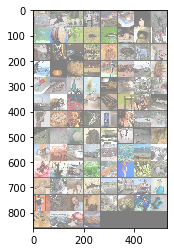

tensor(78) tensor(27) tensor(129) tensor(140) tensor(71) tensor(174) tensor(77) tensor(8) tensor(23) tensor(67) tensor(15) tensor(48) tensor(41) tensor(179) tensor(137) tensor(79) tensor(151) tensor(159) tensor(87) tensor(27) tensor(168) tensor(3) tensor(25) tensor(125) tensor(139) tensor(83) tensor(192) tensor(171) tensor(88) tensor(53) tensor(166) tensor(41) tensor(69) tensor(5) tensor(113) tensor(188) tensor(133) tensor(182) tensor(54) tensor(161) tensor(124) tensor(37) tensor(196) tensor(136) tensor(141) tensor(109) tensor(143) tensor(116) tensor(120) tensor(191) tensor(161) tensor(152) tensor(138) tensor(140) tensor(52) tensor(33) tensor(8) tensor(79) tensor(13) tensor(63) tensor(174) tensor(64) tensor(99) tensor(55) tensor(80) tensor(98) tensor(81) tensor(166) tensor(78) tensor(196) tensor(50) tensor(164) tensor(189) tensor(108) tensor(121) tensor(184) tensor(0) tensor(13) tensor(55) tensor(31) tensor(161) tensor(12) tensor(57) tensor(17) tensor(96) tensor(108) tensor(115) tensor

In [68]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % labels[j] for j in range(100)))

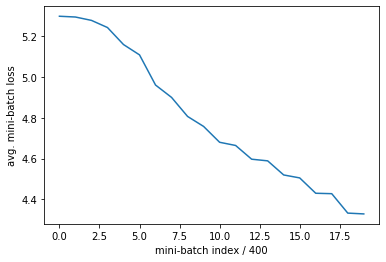

In [36]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [44]:
dir_str = 'tiny-imagenet-200/{}'.format('train')
lst_images = os.listdir(dir_str)
index_dict = {}
classes = []
lst_images.remove('.DS_Store')
for num, image in enumerate(lst_images):
    index_dict[image] = num
    classes.append(image_dict[image])


In [65]:
classes

NameError: name 'classes' is not defined

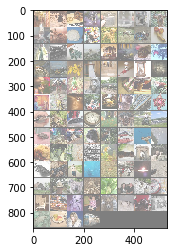

GroundTruth:  barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cask barrel, cas

In [48]:
# Check several images.
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(100)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(100)))

In [47]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 0 %


In [ ]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(200))
class_total = list(0. for i in range(200))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [52]:
def transform_images(data, normalize=True):
    dir_str = 'tiny-imagenet-200/{}'.format(data)
    lst_images = os.listdir(dir_str)
    index_dict = {}
    labels = []
    lst_images.remove('.DS_Store')
    for num, image in enumerate(lst_images):
        index_dict[image] = num
        labels.append(image_dict[image])
                    
    #print(index_dict)
    #print(labels)
    ohe = np.eye(len(index_dict))
    #labels = np.array([])
    total_images = []
    counter = 0
    for image_class in lst_images:
        new_dir = dir_str + '/' + image_class + '/images'
        label = index_dict[image_class]
        for image in os.listdir(new_dir):
            image_data = plt.imread(new_dir+'/'+image)
            #print(new_dir+'/'+image)
            #print(image_data.shape)
            #print(image_dict[image_class])
            image_data = image_data/255
            #plt.imshow(image_data)
            #plt.show()
            #break
            if image_data.shape == (64,64):
                #image_data = image_data.astype(float)
                #print(new_dir+'/'+image)
                img_bucket = np.zeros((64, 64, 3))
                for i in range(3):
                    img_bucket[:,:,i] = image_data
                image_data = img_bucket
                #image_data = image_data.reshape(64, 64, 3)
            total_images.append((image_data, ohe[label]))
            #print(total_images)
        counter += 1
        print(image_class+' done'+ ' ({}/200)'.format(counter))
    return np.array(total_images)

In [53]:
%time train_data = transform_images('train')

n02795169 done (1/200)
n02769748 done (2/200)
n07920052 done (3/200)
n02917067 done (4/200)
n01629819 done (5/200)
n02058221 done (6/200)
n02793495 done (7/200)
n04251144 done (8/200)
n02814533 done (9/200)
n02837789 done (10/200)
n01770393 done (11/200)
n01910747 done (12/200)
n03649909 done (13/200)
n02124075 done (14/200)
n01774750 done (15/200)
n06596364 done (16/200)
n03838899 done (17/200)
n02480495 done (18/200)
n09256479 done (19/200)
n03085013 done (20/200)
n01443537 done (21/200)
n04376876 done (22/200)
n03404251 done (23/200)
n03930313 done (24/200)
n03089624 done (25/200)
n04371430 done (26/200)
n04254777 done (27/200)
n02909870 done (28/200)
n07614500 done (29/200)
n02977058 done (30/200)
n04259630 done (31/200)
n07579787 done (32/200)
n02950826 done (33/200)
n02279972 done (34/200)
n03424325 done (35/200)
n03854065 done (36/200)
n02403003 done (37/200)
n01742172 done (38/200)
n01882714 done (39/200)
n03977966 done (40/200)
n02669723 done (41/200)
n02226429 done (42/200)
n

In [ ]:
%time pkl.dump(train_data, open('tiny-imagenet-200/train.npy', 'wb'))


In [5]:
total_data, index_dict, labels = transform_images('train')

n02795169 done (1/200)
n02769748 done (2/200)
n07920052 done (3/200)
n02917067 done (4/200)
n01629819 done (5/200)
n02058221 done (6/200)
n02793495 done (7/200)
n04251144 done (8/200)
n02814533 done (9/200)
n02837789 done (10/200)
n01770393 done (11/200)
n01910747 done (12/200)
n03649909 done (13/200)
n02124075 done (14/200)
n01774750 done (15/200)
n06596364 done (16/200)
n03838899 done (17/200)
n02480495 done (18/200)
n09256479 done (19/200)
n03085013 done (20/200)
n01443537 done (21/200)
n04376876 done (22/200)
n03404251 done (23/200)
n03930313 done (24/200)
n03089624 done (25/200)
n04371430 done (26/200)
n04254777 done (27/200)
n02909870 done (28/200)
n07614500 done (29/200)
n02977058 done (30/200)
n04259630 done (31/200)
n07579787 done (32/200)
n02950826 done (33/200)
n02279972 done (34/200)
n03424325 done (35/200)
n03854065 done (36/200)
n02403003 done (37/200)
n01742172 done (38/200)
n01882714 done (39/200)
n03977966 done (40/200)
n02669723 done (41/200)
n02226429 done (42/200)
n

OSError: [Errno 28] No space left on device

In [164]:
total_data[0].shape

(200000,)

In [23]:
os.listdir('tiny-imagenet-200/train')

['n02795169',
 'n02769748',
 'n07920052',
 'n02917067',
 'n01629819',
 'n02058221',
 'n02793495',
 'n04251144',
 'n02814533',
 'n02837789',
 'n01770393',
 'n01910747',
 'n03649909',
 'n02124075',
 'n01774750',
 'n06596364',
 'n03838899',
 'n02480495',
 'n09256479',
 'n03085013',
 'n01443537',
 'n04376876',
 'n03404251',
 'n03930313',
 'n03089624',
 'n04371430',
 'n04254777',
 'n02909870',
 'n07614500',
 'n02977058',
 'n04259630',
 'n07579787',
 'n02950826',
 '.DS_Store',
 'n02279972',
 'n03424325',
 'n03854065',
 'n02403003',
 'n01742172',
 'n01882714',
 'n03977966',
 'n02669723',
 'n02226429',
 'n04366367',
 'n02002724',
 'n03891332',
 'n01768244',
 'n02509815',
 'n03544143',
 'n02321529',
 'n02099601',
 'n02948072',
 'n04456115',
 'n02236044',
 'n03126707',
 'n02074367',
 'n03255030',
 'n01950731',
 'n02268443',
 'n04501370',
 'n03970156',
 'n04099969',
 'n04023962',
 'n02085620',
 'n02823428',
 'n04265275',
 'n02113799',
 'n01784675',
 'n03706229',
 'n03100240',
 'n04532106',
 'n027